# Deep Learning with PyTorch: Multi handwritten Digit Recognition based on MNIST dataset

This project involves training a neural network on the MNIST dataset to recognize handwritten digits. The trained model is then applied to classify multi-digit images, showcasing its ability to identify numerical characters.

### Importing Libraries

In [3]:
# PyTorch Library
import torch

# PyTorch Neural Network
from torch import nn, optim

# Pytorch dataset
from torchvision import datasets

# Allows us to transform tensors
import torchvision.transforms as transforms

# Open CV
import cv2

# Package for visualization
import matplotlib.pylab as plt

# Numpy for array vector
import numpy as np

# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(2);

# Part I: Create model using MNIST data

### Data Loading and Visualization

Load train and validation data

In [4]:
%%capture
train_data = datasets.MNIST(root='',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
validation_data = datasets.MNIST(root='',
                                 train=False,
                                 download=True,
                                 transform=transforms.ToTensor())

Create train and validation dataloader object

In [5]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size = 100,
    shuffle = True)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_data,
    batch_size = 100,
    shuffle = True)

Once, we've load data, it is a good practice to take a loot at a sample data

In [6]:
examples = iter(validation_loader)
example_data, example_targets = next(examples)

Visualize some samples from our data

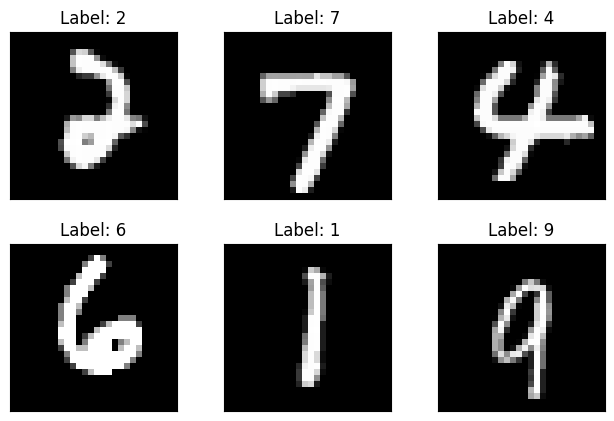

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Neural Network Model Definition

Now, we can proceed to the model creation

In [8]:
def create_model(input_size, hidden_dim1, hidden_dim2, output_size):

    model = nn.Sequential(
        nn.Linear(input_size, hidden_dim1),
        nn.ReLU(),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU(),
        nn.Linear(hidden_dim2, output_size),
        nn.LogSoftmax(dim=1)
    )

    return model

In [9]:
def train(
        model, input_size, criterion, train_loader, validation_loader, optimizer, epochs
):

    model_metrics = {'training_loss': [], 'validation_accuracy': []}

    for epoch in range(epochs):
        running_loss = 0

        for iteration, (images, label) in enumerate(train_loader):
            optimizer.zero_grad()

            # make prediction
            yhat = model(images.view(-1, input_size))

            # Calculate loss
            loss = criterion(yhat, label)

            loss.backward()
            optimizer.step()
            running_loss += loss.data

        model_metrics['training_loss'].append(running_loss)

        # track correct prediction
        correct = 0
        for img, target in validation_loader:

            # make prediction
            yhat = model(img.view(-1, input_size))

            # Get the class that has the maximum value
            _, label = torch.max(yhat, 1)

            # Chech if the predicted value matches with the actuall class
            correct += (label == target).sum().item()


        accuracy = 100 * (correct / len(validation_loader.dataset))

        model_metrics['validation_accuracy'].append(accuracy)

    return model_metrics

### Training Setup

In [10]:
input_size = example_data.shape[2]*example_data.shape[3]
hidden_dim1 = 128
hidden_dim2 = 64
output_size = 10

# Create a model instance
model = create_model(input_size, hidden_dim1, hidden_dim2, output_size)

# Create the criterion
criterion = nn.CrossEntropyLoss()

# The learning rate
learning_rate = 0.001

# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

### Train the model

In [11]:
training_model = train(model, input_size, criterion, train_loader, validation_loader, optimizer, epochs=10)

## Evaluate the model

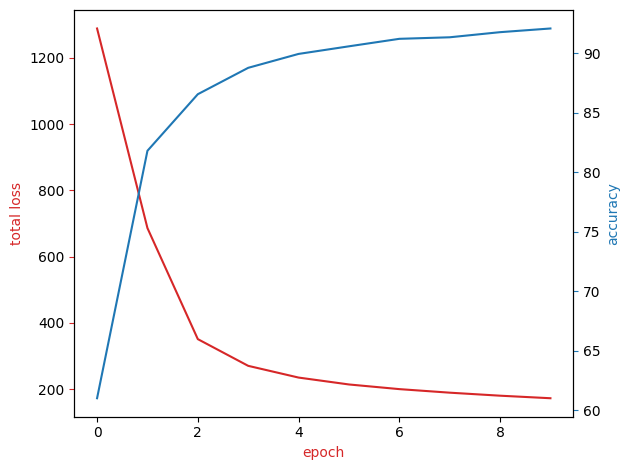

In [12]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(training_model['training_loss'], color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis = 'y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(training_model['validation_accuracy'], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.show()

# Let's test the model using a sample from the validation data

In [13]:
# Peek a random image
image_val, label_pred = next(iter(validation_loader))
img = image_val[3].view(-1, input_size)

In [14]:
# Make prediction
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
proba = list(ps.numpy()[0])

In [15]:
def view_classify(img, ps):

    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.view(28, 28), cmap = 'gray_r')
    ax1.axis('off')

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_ylabel('Class label')
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probability')
    ax2.tick_params(direction = 'in')
    ax2.set_xlim(0, 1.1)
    ax2.grid(True, alpha = 0.2)
    plt.tight_layout()

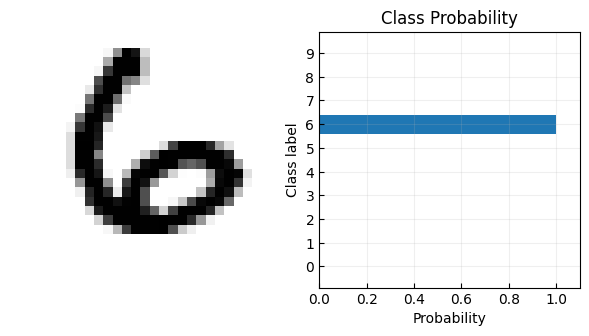

In [16]:
view_classify(img.view(1, 28, 28), ps)

# Part II: Multi-digit classification

### Read the sample image

In [17]:
img_path = "mnist_test.png"
sample_image = cv2.imread(img_path)

### Visualize the sample image

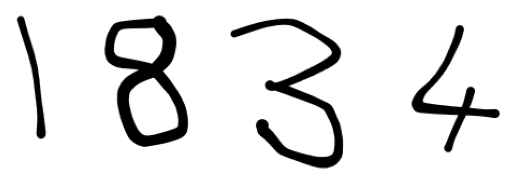

In [18]:
image_gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
image_copy = image_gray.copy()
plt.imshow(image_gray, cmap='gray')
plt.axis('off');

### Increase thickness of digits

In [19]:
# Dilate image
kernel_one = np.ones((1,1), np.uint8) # The kernel
img_dilation = cv2.dilate(image_gray, kernel_one, iterations=1)

# Detect egde
edged = cv2.Canny(img_dilation, 30, 200)

# Dilate image
kernel_three = np.ones((3,3), np.uint8) # Another kernel
edged_image = cv2.dilate(edged, kernel_three, iterations=1)

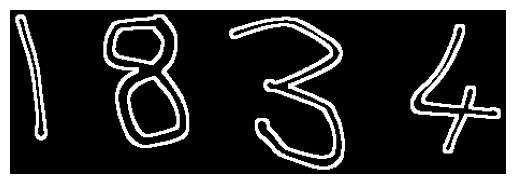

In [40]:
plt.imshow(edged_image, cmap='gray');
plt.axis('off');

### Detect contours and segmentation

In [21]:
# Contours
contours, _ = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Segmentation
cnts = sorted(contours, key = cv2.boundingRect)

### Rectangle the detected digits

In [31]:
# Store segmented images
image_list = []
for c in cnts:
    x_coor, y_coor, width, height = cv2.boundingRect(c)
    region = 255 - image_copy[y_coor:y_coor+height, x_coor:x_coor+width]
    image_list.append(region)
    cv2.rectangle(image_gray, (x_coor, y_coor), (x_coor+width, y_coor+height), (36, 255, 12), 2)

### Visualize the segmented image

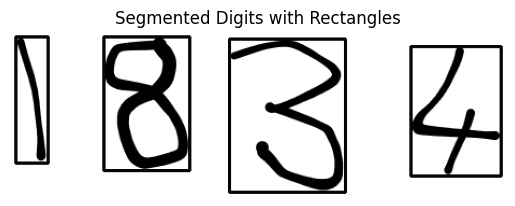

In [32]:
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.title('Segmented Digits with Rectangles')
plt.show()

### Display individual segmented images

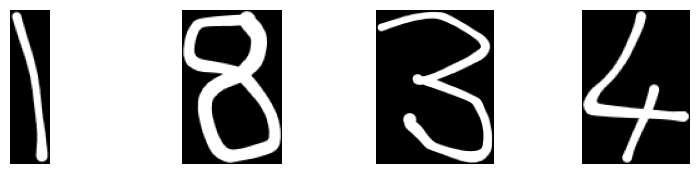

In [33]:
plt.figure(figsize=(10, 2))
for i, digit in enumerate(image_list, 1):
    plt.subplot(1, len(image_list), i)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
plt.show()

### Add border
This process is inspired by the fact that each images in the MNIST has border.

In [34]:
# Adding border

# Modify segmented images
image_list_border = []
border_frac = 0.3
for im in image_list:
    # add padding of black border
    img_with_border = cv2.copyMakeBorder(
        im,
        int(np.ceil(im.shape[1]*border_frac)),
        int(np.ceil(im.shape[1]*border_frac)),
        int(np.ceil(im.shape[0]*border_frac)),
        int(np.ceil(im.shape[0]*border_frac)),
        cv2.BORDER_CONSTANT,
        value=0
    )

    # Add the modified image to the list
    image_list_border.append(img_with_border)

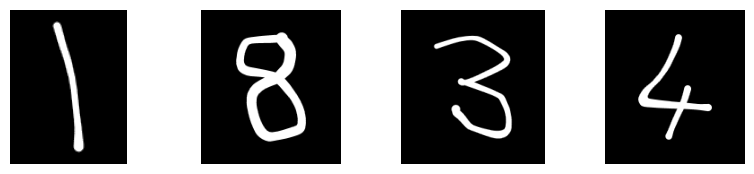

In [35]:
# Display individual segmented images
plt.figure(figsize=(10, 2))
for i, digit in enumerate(image_list_border, 1):
    plt.subplot(1, len(image_list), i)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
plt.show()

## Resize the extracted number
To accommodate the input requirements of the model, which only accepts images with a size of 28x28 pixels, it is necessary to resize the extracted number. This can be achieved through a resizing operation to adjust the dimensions of the image to 28x28 pixels while preserving its numerical content.

In [36]:
# Resize
resized_image = []
plt.figure(figsize=(10, 2))
for i, digit in enumerate(image_list_border, 1):
    image = cv2.resize(digit, (28, 28), interpolation = cv2.INTER_AREA)
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)

    # Store it in the list
    resized_image.append(image)

<Figure size 1000x200 with 0 Axes>

### Visualize the resized image

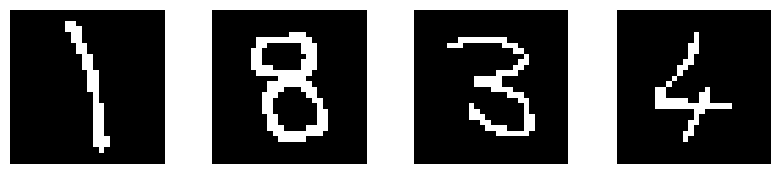

In [37]:
plt.figure(figsize=(10, 2))
for i, digit in enumerate(resized_image, 1):
    plt.subplot(1, len(image_list_border), i)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
plt.show()

## Make prediction using the previous model
Now our images are ready for prediction

In [38]:
# Make prediction and store the result in an empty list
result = []
for image in resized_image:

    input_image = torch.tensor((image/255.0), dtype=torch.float32)
    with torch.no_grad():
        logps = model(input_image.view(-1, input_size))
    ps = torch.exp(logps)
    result.append(np.argmax(list(ps.numpy()[0])))

In [39]:
result_number = int(''.join(map(str, result)))
print(result_number)

1834
